In [1]:
import pytesseract
from pytesseract import Output
import cv2
from pdf2image import convert_from_path
import os
import glob
#from repositories import TableRepositories
#from repositories import RectRepositories
#import config
import matplotlib.pyplot as plt
import uuid
import pandas as pd
import numpy as np



In [2]:
class OCRlineRepositoriesv3:

    def __init__(self, pdf_path):
        self.pdf_path          = pdf_path
        self.response          = {'resolution': None , 'lines_data': []}
        self.language_map      = {'Malayalam' : 'mal' , 'Tamil':'tam' , 'Devanagari':'hin','Telugu':'tel','Latin':'eng'}
        self.pdf_language      = 'eng'
        self.margin_support    = 4
        self.tesseract_conf    = 0
        self.page_df           = None
        self.pdf_to_html_width = None
        self.pdf_to_image ()
        self.pdf_language_detect ()
        self.line_metadata()
        #self.delete_images()


    def pdf_to_image(self):
        self.pdf_name = self.pdf_path.split('/')[-1].split('.')[0]
        self.pdf_to_image_dir  = 'tmp/images/' + self.pdf_name + str(uuid.uuid1())
        os.system('mkdir -p {0}'.format (self.pdf_to_image_dir))
        convert_from_path(self.pdf_path, output_folder=self.pdf_to_image_dir, fmt='jpeg', output_file='')#,poppler_path=".\bin\poppler\bin")
        os.system(' pdftohtml -s -c -p {0} {1}/c'.format(self.pdf_path , self.pdf_to_image_dir))
        self.num_of_pages = len(glob.glob(self.pdf_to_image_dir + '/*.png'))
        self.number_of_digits = len(str(self.num_of_pages))

    def pdf_language_detect(self):
        page_file         = self.pdf_to_image_dir + '/-' + self.page_num_correction (0) + '.jpg'

        try :
            osd = pytesseract.image_to_osd(page_file)
            language_script = osd.split('\nScript')[1][2:]
            self.pdf_language = self.pdf_language + '+' + self.language_map[language_script]
        except :
            pass
        print( 'Language detected {0}'.format(self.pdf_language))

    def mask_out_tables(self, table_detect_file, page):
        #loading and binarisation
        page_image = cv2.imread(page,0)
        
        '''

        table_image = cv2.imread (table_detect_file, 0)
        table_image = table_image > 100
        table_image = table_image.astype(np.uint8) *255
        #cv2.imwrite('1.png',table_image )

        tables     = TableRepositories (table_image)

        if self.pdf_to_html_width == None :
            self.pdf_to_html_width = float(tables.input_image.shape[1])
            self.pdf_to_html_height = float(tables.input_image.shape[0])

        y_scale = page_image.shape[0] / float(tables.input_image.shape[0])
        x_scale = page_image.shape[1] / float(tables.input_image.shape[1])
        table_rois = tables.response ["response"] ["tables"]

        Rects = RectRepositories(table_image)
        lines, _ = Rects.get_tables_and_lines()
        lines = self.scale_lines(lines,x_scale,y_scale)
        #print(tables.response)
        table_text =[]
        if len (table_rois) != 0:
           
            for table in table_rois:
                table = self.table_parser(table,page_image,y_scale,x_scale)
                x = table ['x']
                y = table ['y']
                w = table ['w']
                h = table ['h']
                table_text.append(table)
                
            return page_image ,table_text,lines
        else :
            return page_image ,[],lines
        '''
        return page_image , None ,None


    def scale_lines(self,lines,x_scale,y_scale):
        len_lines = len(lines)
        if len_lines > 0:
            for i in range(len_lines):
                lines[i]['x'] = int( lines[i]['x'] * x_scale)
                lines[i]['y'] = int(lines[i]['y'] * y_scale)
                lines[i]['w'] = int(lines[i]['w'] * x_scale)
                lines[i]['h'] = int(lines[i]['h'] * y_scale)
                
        return lines
        

    def table_parser(self,table_response,page_image,y_scale,x_scale):
        cells     = table_response['rect']
        origin_x  = table_response['x'] * x_scale
        origin_y  = table_response['y'] * y_scale

        cells_count = len(cells)
        if cells_count > 0 :
            for i in range(cells_count):
                xstart  =   origin_x + table_response['rect'][i]['x'] * x_scale
                xend    =   xstart   +   table_response['rect'][i]['w'] * x_scale
                ystart  =   origin_y + table_response['rect'][i]['y'] * y_scale
                yend    = ystart + table_response['rect'][i]['h'] * y_scale

                crop_fraction = page_image[int(ystart): int(yend), int(xstart):int(xend)]
                text = pytesseract.image_to_string(crop_fraction,lang=self.pdf_language,config='--psm 11')
                table_response['rect'][i] = {'x' : int(xstart) ,'y':int(ystart), 'w':int( xend-xstart),'h':int(yend-ystart) , 'index':table_response['rect'][i]['index'] ,'text':text }
        table_response['x'] = int(origin_x)
        table_response['y']  = int(origin_y)
        table_response['w']  = int(table_response['w'] * x_scale)
        table_response['h']  = int(table_response['h'] *y_scale)


        return table_response

    def bloat_text(self, image):
        # converitng image to binary
        #image = image > 100
        #image = image.astype(np.uint8)
        # Bloating
        dist_transform = cv2.distanceTransform(image, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, self.line_spacing_median * 0.5, 255, 0)
        #cv2.imwrite( str(uuid.uuid1()) +'.png' ,sure_fg)
        return sure_fg.astype(np.uint8)

    def sort_words(self, group, sorted_group=None, line_spacing=None, line=0):

        if line_spacing is None:
            line_spacing = []
        if sorted_group is None:
            sorted_group = []
        semi_height = group.iloc[0]['height'] #/ 2.0
        check_y = group.iloc[0]['top']
        same_line = group[abs(group['top'] - check_y) < semi_height]
        next_lines = group[abs(group['top'] - check_y) >= semi_height]
        sort_lines = same_line.sort_values(by=['left'])
        sort_lines['line'] = line
        line_spacing.append(same_line['ymid'].mean())
        line += 1
        for index, row in sort_lines.iterrows():
            sorted_group.append(row)

        if len(next_lines) > 0:
            self.sort_words(next_lines, sorted_group, line_spacing, line)

        return sorted_group, line_spacing, line

    def sort_contours(self, contours_df, sorted_contours=None):

        if sorted_contours is None:
            sorted_contours = []
        check_y = contours_df.iloc[0]['top']

        same_line = contours_df[abs(contours_df['top'] - check_y) < self.line_spacing_median*0.5]
        next_lines = contours_df[abs(contours_df['top'] - check_y) >= self.line_spacing_median*0.5]
        sort_lines = same_line.sort_values(by=['left'])
        for index, row in sort_lines.iterrows():
            sorted_contours.append(row)
        if len(next_lines) > 0:
            self.sort_contours(next_lines, sorted_contours)

        return sorted_contours

    def median_spacing(self,line_spacing):
        spacing = []
        for i in range(len(line_spacing) - 1):
            spacing.append(line_spacing[i + 1] - line_spacing[i])
        spacing_median = np.median(spacing)

        return spacing_median

    def find_and_sort_contours(self,bloated_image):
        contours = cv2.findContours(bloated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        image_area = bloated_image.shape[0] * bloated_image.shape[1]
        contours_list = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if (w * h) < (image_area * 0.95):
                contours_list.append([x, y, w, h])
        contours_df = pd.DataFrame(contours_list, columns=['left', 'top', 'width', 'height'])
        contours_df = contours_df.sort_values(by=['top'])
        sorted_contours = self.sort_contours(contours_df, [])
        sorted_contours = pd.DataFrame(sorted_contours).reset_index()

        return sorted_contours

    def extract_region(self, row):
        sub_text_df = self.page_df[
            (self.page_df['left'] >= row['left']) & (self.page_df['right'] <= (row['left'] + row['width'])) & (
                        self.page_df['top'] >= row['top']) & (self.page_df['bottom'] <= (row['top'] + row['height']))]

        return sub_text_df

    def line_start_and_end_stats(self):
        lines = self.page_df['line'].unique()
        lines_df = pd.DataFrame(lines, columns=['line'])
        lines_df['start'] = 0
        lines_df['end'] = 0
        for line in lines:
            sub_sorted_df = self.page_df[self.page_df['line'] == line]
            lines_df['start'][line] = sub_sorted_df['left'].min()
            lines_df['end'][line] = sub_sorted_df['right'].max()

        return lines_df

    def extraction_helper(self, input_image):
    
        text_df = pytesseract.image_to_data(input_image, lang=self.pdf_language, output_type=Output.DATAFRAME)
        text_df = text_df[text_df['conf'] > self.tesseract_conf]
        if len(text_df) > 0:
            text_df['bottom']   = text_df['top'] + text_df['height']
            text_df['right']    = text_df['left'] + text_df['width']
            text_df['ymid']     = text_df['top'] + text_df['height'] * 0.5
            text_df             = text_df.sort_values(by=['top'])
            text_df['text']     = text_df['text'].astype(str)
            text_df['line']     = None
            text_df['line_key'] = text_df['block_num'].astype(str) + text_df['par_num'].astype(str) + text_df['line_num'].astype(str)
            self.median_height  = text_df['height'].median()
            # Removing noise
            text_df             = text_df[text_df['height'] > (self.median_height / 2.0)]
            text_df = text_df[text_df['text'] != ' ']


            sorted_df, line_spacing, line = self.sort_words(text_df, sorted_group=[], line_spacing=[], line=0)

            self.page_df = pd.DataFrame(sorted_df).reset_index()
            self.line_df = self.line_start_and_end_stats()
            self.line_spacing_median = self.median_spacing(line_spacing)
            bloated_image = self.bloat_text(input_image)
            self.sorted_contours = self.find_and_sort_contours(bloated_image)

            return 'Found text'
        else:
            return None

    def get_left_margin(self):
        line_start_distribution = np.array(sorted(self.line_df['start']))
        threshold = self.page_df['height'].median()
        # check support

        for starting_point in line_start_distribution:
            delta = abs(line_start_distribution - starting_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return starting_point

    def get_right_margin(self):
        line_end_distribution = np.array(sorted(self.line_df['end'], reverse=True))
        threshold = self.page_df['height'].median()
        # check support

        for end_point in line_end_distribution:
            delta = abs(line_end_distribution - end_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return end_point

    def word_conf(self,sub_df):
        word_conf = []
        for index, row in sub_df.iterrows():
            word_conf.append({row['text']: row['conf']})

        return word_conf

    def line_parser(self, page_number, pdf_index):
        lines_data = []
        # page_number = 1
        # pdf_index =   0

        for index, row in self.sorted_contours.iterrows():
            extracted_region = self.extract_region(row)
            blob_start = row['left']
            if len(extracted_region) > 0:
                # print(extracted_region)
                lines_in_blob = extracted_region['line'].unique()
                lines_count = len(lines_in_blob)
                first_line = lines_in_blob[0]
                last_line = lines_in_blob[-1]
                for line_id in lines_in_blob:
                    line = {}
                    same_line = extracted_region[extracted_region['line'] == line_id]
                    # print(same_line)
                    line['text'] = ' '.join(same_line['text'].values)
                    line['top'] = int(same_line['top'].min())
                    line['left'] = int(same_line['left'].min())
                    line['height'] = int(same_line['height'].max())
                    line['right'] = int(same_line['right'].max())
                    line['bottom'] = int(same_line['bottom'].max())

                    line['block_num'] = int(same_line['block_num'].iloc[0])
                    line['blob_id'] = int(index)
                    line['pdf_index'] = int(pdf_index)
                    line['page_no'] = int(page_number)
                    line['avrage_conf'] = float(same_line['conf'].mean())
                    line['page_line_index'] = int(line_id)
                    line['word_conf']      = self.word_conf(same_line)
                    line['visual_break'] = self.break_condition( line_id, last_line, page_number, lines_count)

                    pdf_index += 1
                    lines_data.append(line)

        return lines_data, pdf_index




    def page_num_correction(self,page_num,num_size=None):
        padding = '0'
        if num_size == None :
            max_length = self.number_of_digits
        else :
            max_length = num_size
        corrction_factor = max_length - len(str(page_num + 1 ))
        return padding * corrction_factor + str(page_num + 1)



    def line_metadata(self):
        pdf_index=0
        for page_num in range(self.num_of_pages):
            page_file                      = self.pdf_to_image_dir + '/-' + self.page_num_correction(page_num) + '.jpg'
            table_detect_file              = self.pdf_to_image_dir + '/c' + self.page_num_correction(page_num,3) + '.png'
            page_image ,table_text,lines   = self.mask_out_tables(table_detect_file, page_file)
            print(table_detect_file,page_file)

            try :
                check_for_text = self.extraction_helper(page_image)
            except :
                check_for_text = None
            #check_for_text = self.extraction_helper(page_image)

            if (check_for_text != None)  :
                line_data, pdf_index    = self. line_parser(page_num +1, pdf_index)
                self.response['lines_data'].append({'line_data':line_data ,'table_data':table_text,'lines':lines})
            else :
                if (table_text != None):
                    self.response['lines_data'].append({'line_data': None, 'table_data': table_text,'lines':lines})
                else:
                    self.response['lines_data'].append({'line_data': None, 'table_data': None,'lines':lines})

            if self.response['resolution'] == None:
                self.response['resolution'] = {'x':page_image.shape[1] , 'y':page_image.shape[0]}




    # visual_break for judgement documents 
    def break_condition(self, line_id, last_line, page_number, lines_count):
        left_margin = self.get_left_margin()
        right_margin = self.get_right_margin()
        line_start = self.line_df['start'][line_id]
        line_ending = self.line_df['end'][line_id]
        start_delta = abs(line_start - left_margin)
        end_delta = abs(right_margin - line_ending)

        if line_id == last_line:
            # Adding exception for last line of page
            if (start_delta < 3 * self.median_height) & (end_delta < 2 * self.median_height):
                return 0
            else:
                return 1
        else:
            # First pages uses centre alignment for headings and titles
            if page_number == 1:
                if start_delta > 3 * self.median_height:
                    if end_delta > 2 * self.median_height:
                        return 1
                else:
                    if lines_count > 3:
                        if end_delta > 2 * self.median_height:
                            return 1
            else:
                # Supreme court uses justified text alignment
                if start_delta < 2 * self.median_height:
                    if end_delta > 2 * self.median_height:
                        return 1
                else:
                    if abs(line_start - self.line_df['start'][line_id + 1]) > 2 * self.median_height:
                        if abs(line_ending - self.line_df['end'][line_id + 1]) > 2 * self.median_height:
                            return 1

        return 0

    def delete_images(self):
        os.system('rm -r {0}'.format(self.pdf_to_image_dir))
        
        

In [25]:

def show_df(df):
    return df.head(df.shape[0])


def show_breaks(input_image,lines_data):
    output_image = cv2.imread(input_image)
    for index, line in lines_data.iterrows():
        if line['visual_break']:
            cv2.rectangle(output_image, (line['left'], line['top']), (line['right'], line['bottom']), (255,0,0), 2)

        else :
             cv2.rectangle(output_image, (line['left'], line['top']), (line['right'], line['bottom']), (0,255,0), 2)
                
    plt.imshow(output_image)
    #return output_image
    
    
    
def group_paragraph_and_sentence(page_df):
    
    grouped_data =[]
    blobs =  page_df['blob_id'].unique()
    for blob in blobs:
        page_dic = {}
        sub_df = page_df[page_df['blob_id'] == blob]
        page_dic['left']     = sub_df['left'].min()
        page_dic['right']    = sub_df['right'].max()
        page_dic['top']      = sub_df['top'].min()
        page_dic['bottom']   = sub_df['bottom'].max()
        page_dic['lines']    = sub_df['text'].values
        lines_count          = len(sub_df)
        page_dic['agg_lines']= group_by_visual_break(sub_df,lines_count)
        
        grouped_data.append(page_dic)
        
    return pd.DataFrame(grouped_data)



def group_by_visual_break(sub_df, lines_count):
    text_chunks = ['']
    text_chunks  = text_chunks * 16
    visual_index = 0
    for index, row in sub_df.iterrows():
        text_chunks[visual_index]  = text_chunks[visual_index] + ' ' + row['text']
        visual_index += row['visual_break']

    text_chunks = [text for text in text_chunks  if text !='']
    
    return text_chunks
    
            

In [23]:
base_dir   = '/home/dhiraj/Documents/Anuwad/document-structure/data/input'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = '12_2019_9_1503_21076_Judgement_02-Mar-2020.pdf'
file_path  = base_dir + '/' + filename
 


os.system('mkdir -p {0}'.format(input_dir))
os.system('mkdir -p {0}'.format(output_dir))


0

In [24]:
ocr_output = OCRlineRepositoriesv3(file_path)

Language detected eng+eng
tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/c001.png tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/-01.jpg
tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/c002.png tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/-02.jpg
tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/c003.png tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/-03.jpg
tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/c004.png tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/-04.jpg
tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc74/c005.png tmp/images/12_2019_9_1503_21076_Judgement_02-Mar-2020262b9132-d097-11ea-890d-3f60d770fc

In [51]:
page_index = 1
    
page_file  = ocr_output.pdf_to_image_dir + '/-' + ocr_output.page_num_correction(page_index) + '.jpg'
page_df    = pd.DataFrame(ocr_output.response['lines_data'][page_index]['line_data'])

group_paragraph_and_sentence = group_paragraph_and_sentece(page_df)

In [52]:
show_df(page_df)

,text,top,left,height,right,bottom,block_num,blob_id,pdf_index,page_no,avrage_conf,page_line_index,word_conf,visual_break
0,the appellant who is one of the accused and is...,209,201,35,1498,244,1,0,19,2,95.307692,0,"[{'the': 96}, {'appellant': 96}, {'who': 96}, ...",0
1,appellant has preferred the present appeal.,298,202,35,854,333,1,0,20,2,96.166667,1,"[{'appellant': 96}, {'has': 96}, {'preferred':...",1
2,2. The facts leading to the present appeal in ...,385,187,43,1276,428,1,0,21,2,95.615385,2,"[{'2.': 89}, {'The': 96}, {'facts': 96}, {'lea...",1
3,"That in an earthquake on 26.01.2001, number of...",477,301,35,1497,512,1,0,22,2,95.700000,3,"[{'That': 96}, {'in': 96}, {'an': 95}, {'earth...",0
4,including the building named Shikhar Apartment...,567,201,35,1497,602,1,0,23,2,93.700000,4,"[{'including': 96}, {'the': 96}, {'building': ...",0
5,Ahmedabad. That due to the collapse of the sai...,656,201,35,1496,691,1,0,24,2,94.769231,5,"[{'Ahmedabad.': 93}, {'That': 93}, {'due': 95}...",0
6,died. That the private respondent herein-the v...,746,202,36,1496,782,1,0,25,2,95.461538,6,"[{'died.': 95}, {'That': 96}, {'the': 97}, {'p...",0
7,1-58 of 2001 with the Satellite Police Station...,835,202,35,1497,870,1,0,26,2,95.571429,7,"[{'1-58': 91}, {'of': 96}, {'2001': 96}, {'wit...",0
8,"the offences punishable under Sections 304, 41...",924,201,35,1498,959,1,0,27,2,95.857143,8,"[{'the': 96}, {'offences': 96}, {'punishable':...",0
9,"3(2)(c)&(d), Section 7(1)(i)(ii)2 and Section ...",1014,202,35,1497,1049,1,0,28,2,93.166667,9,"[{'3(2)(c)&(d),': 91}, {'Section': 93}, {'7(1)...",0


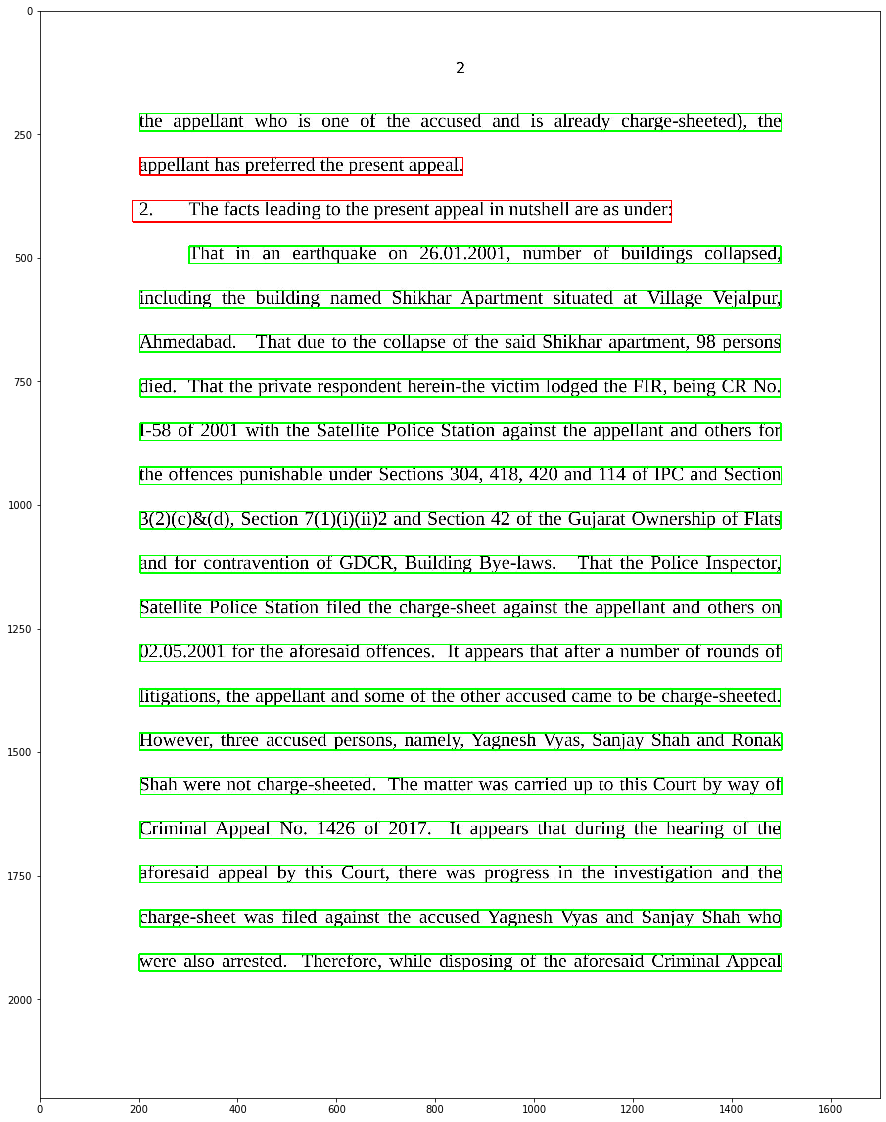

In [53]:
plt.rcParams['figure.figsize'] = [20, 20]
show_breaks(page_file,page_df)

In [54]:
group_paragraph_and_sentence

,left,right,top,bottom,lines,agg_lines
0,187,1499,209,1943,[the appellant who is one of the accused and i...,[ the appellant who is one of the accused and ...


In [55]:
block_index = 0
group_paragraph_and_sentence['agg_lines'][block_index]

[' the appellant who is one of the accused and is already charge-sheeted), the appellant has preferred the present appeal.',
 ' 2. The facts leading to the present appeal in nutshell are as under:',
 ' That in an earthquake on 26.01.2001, number of buildings collapsed, including the building named Shikhar Apartment situated at Village Vejalpur, Ahmedabad. That due to the collapse of the said Shikhar apartment, 98 persons died. That the private respondent herein-the victim lodged the FIR, being CR No. 1-58 of 2001 with the Satellite Police Station against the appellant and others for the offences punishable under Sections 304, 418, 420 and 114 of IPC and Section 3(2)(c)&(d), Section 7(1)(i)(ii)2 and Section 42 of the Gujarat Ownership of Flats and for contravention of GDCR, Building Bye-laws. That the Police Inspector, Satellite Police Station filed the charge-sheet against the appellant and others on 02.05.2001 for the aforesaid offences. It appears that after a number of rounds of lit